In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_squared_log_error
from Code.Torsh.TorchMacsumAggregationLearning import *
from Code.Torsh.Torsh_data_generation import *
import torch.nn.functional as F
from Code.Torsh.NetowrkMacsum import MacsumNetWithActivation
from catboost import CatBoostClassifier, Pool

%load_ext autoreload
%autoreload 2

Using device: cpu


In [2]:
df = pd.read_csv("train.csv")
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
Y = df['Calories'].to_numpy()
df = df.drop(columns=['id','Calories'])
X = df.to_numpy()
print(X.shape)
print(X[:5],Y[:5])

(750000, 7)
[[  0.   36.  189.   82.   26.  101.   41. ]
 [  1.   64.  163.   60.    8.   85.   39.7]
 [  1.   51.  161.   64.    7.   84.   39.8]
 [  0.   20.  192.   90.   25.  105.   40.7]
 [  1.   38.  166.   61.   25.  102.   40.6]] [150.  34.  29. 140. 146.]


In [ ]:
model = MacsumSigmoidTorch(X.shape[1],alpha=0.1,gamma = 0.8,k_sigmoid=0.1)
model.fit_adam(X[:10000],Y[:10000],X[10001:11000],Y[10001:11000],learning_rate=1e-3,epsilon_conv=1e-6,n_epochs = 1000,beta1=0.8,beta2=0.99,batch_size=256)

Starting PyTorch Adam training (MacsumSigmoidTorch with Manual Gradient for Phi)...


Adam Training (MacsumSigmoidTorch Manual Grad):  26%|██▌       | 259/1000 [00:06<00:19, 38.68it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10324c2b0>>
Traceback (most recent call last):
  File "/Users/isaac/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Adam Training (MacsumSigmoidTorch Manual Grad):  68%|██████▊   | 676/1000 [00:18<00:09, 35.76it/s]

In [12]:
model = MacsumNetWithActivation([7,10,10,1],model_class= MacsumSigmoidTorch,activation_fn=F.gelu,alpha=0.8,gamma = 0.8,k_sigmoid=0.1)
model.fit_autograd(X[:10000],Y[:10000],X[10001:11000],Y[10001:11000],learning_rate=1e-3,epsilon_conv=1e-6,n_epochs =  500,beta1=0.8,beta2=0.99,batch_size=256)

Création d'un MacsumNet avec la fonction d'activation: gelu
Starting PyTorch Autograd training for MacsumNet...


Autograd Training (MacsumNet): 100%|██████████| 500/500 [03:17<00:00,  2.54it/s]

Training finished.


MacsumNetWithActivation(
  (layers): ModuleList(
    (0-1): 2 x MacsumLayer(
      (macsum_units): ModuleList(
        (0-9): 10 x MacsumSigmoidTorch()
      )
    )
    (2): MacsumLayer(
      (macsum_units): ModuleList(
        (0): MacsumSigmoidTorch()
      )
    )
  )
)

### nb data


In [14]:
#l=[]
#for i in range(1,51):
#    model = MacsumSigmoidTorch(X.shape[1],alpha=0.1,gamma=0.8,k_sigmoid=0.1)
#    model.fit_adam(X[:i*100],Y[:i*100],learning_rate=1e-3,epsilon_conv=1e-6,n_epochs = 1000,beta1=0.8,beta2=0.99,batch_size=256)
#    l.append(evaluate_model_complet(X[10000:],Y[10000:],model)["containment_rate"])
#plt.plot(l)
#plt.title("plot en fonction du nombre 100 ete d'exemple")
#plt.xlabel("nombr d'exemple dans le data set * 100")
#plt.ylabel("Valeur")
#plt.grid(True)
#plt.show()

In [14]:
i= [ 300000,300005 , 30000]
print(Y[i])
model.forward( torch.tensor(X[i], dtype=torch.float64)) 

[60. 67. 40.]


(tensor([0., 0., 0.], dtype=torch.float64, grad_fn=<SqueezeBackward1>),
 tensor([138.0376, 125.4602, 105.7634], dtype=torch.float64,
        grad_fn=<SqueezeBackward1>))

In [15]:
print(evaluate_model_complet(X,Y,model))
print(np.mean(Y))

{'containment_rate': 0.9734853333333333, 'avg_misp_distance': 9.855319208571615, 'avg_eval_loss': 136.91062297084198, 'avg_train_loss': nan, 'avg_interval_spread': 135.1114170405076, 'median_interval_spread': 135.52924646199838, 'q95_interval_spread': 221.5906916997098, 'phi_distance_l2_normal': None}
88.28278133333333


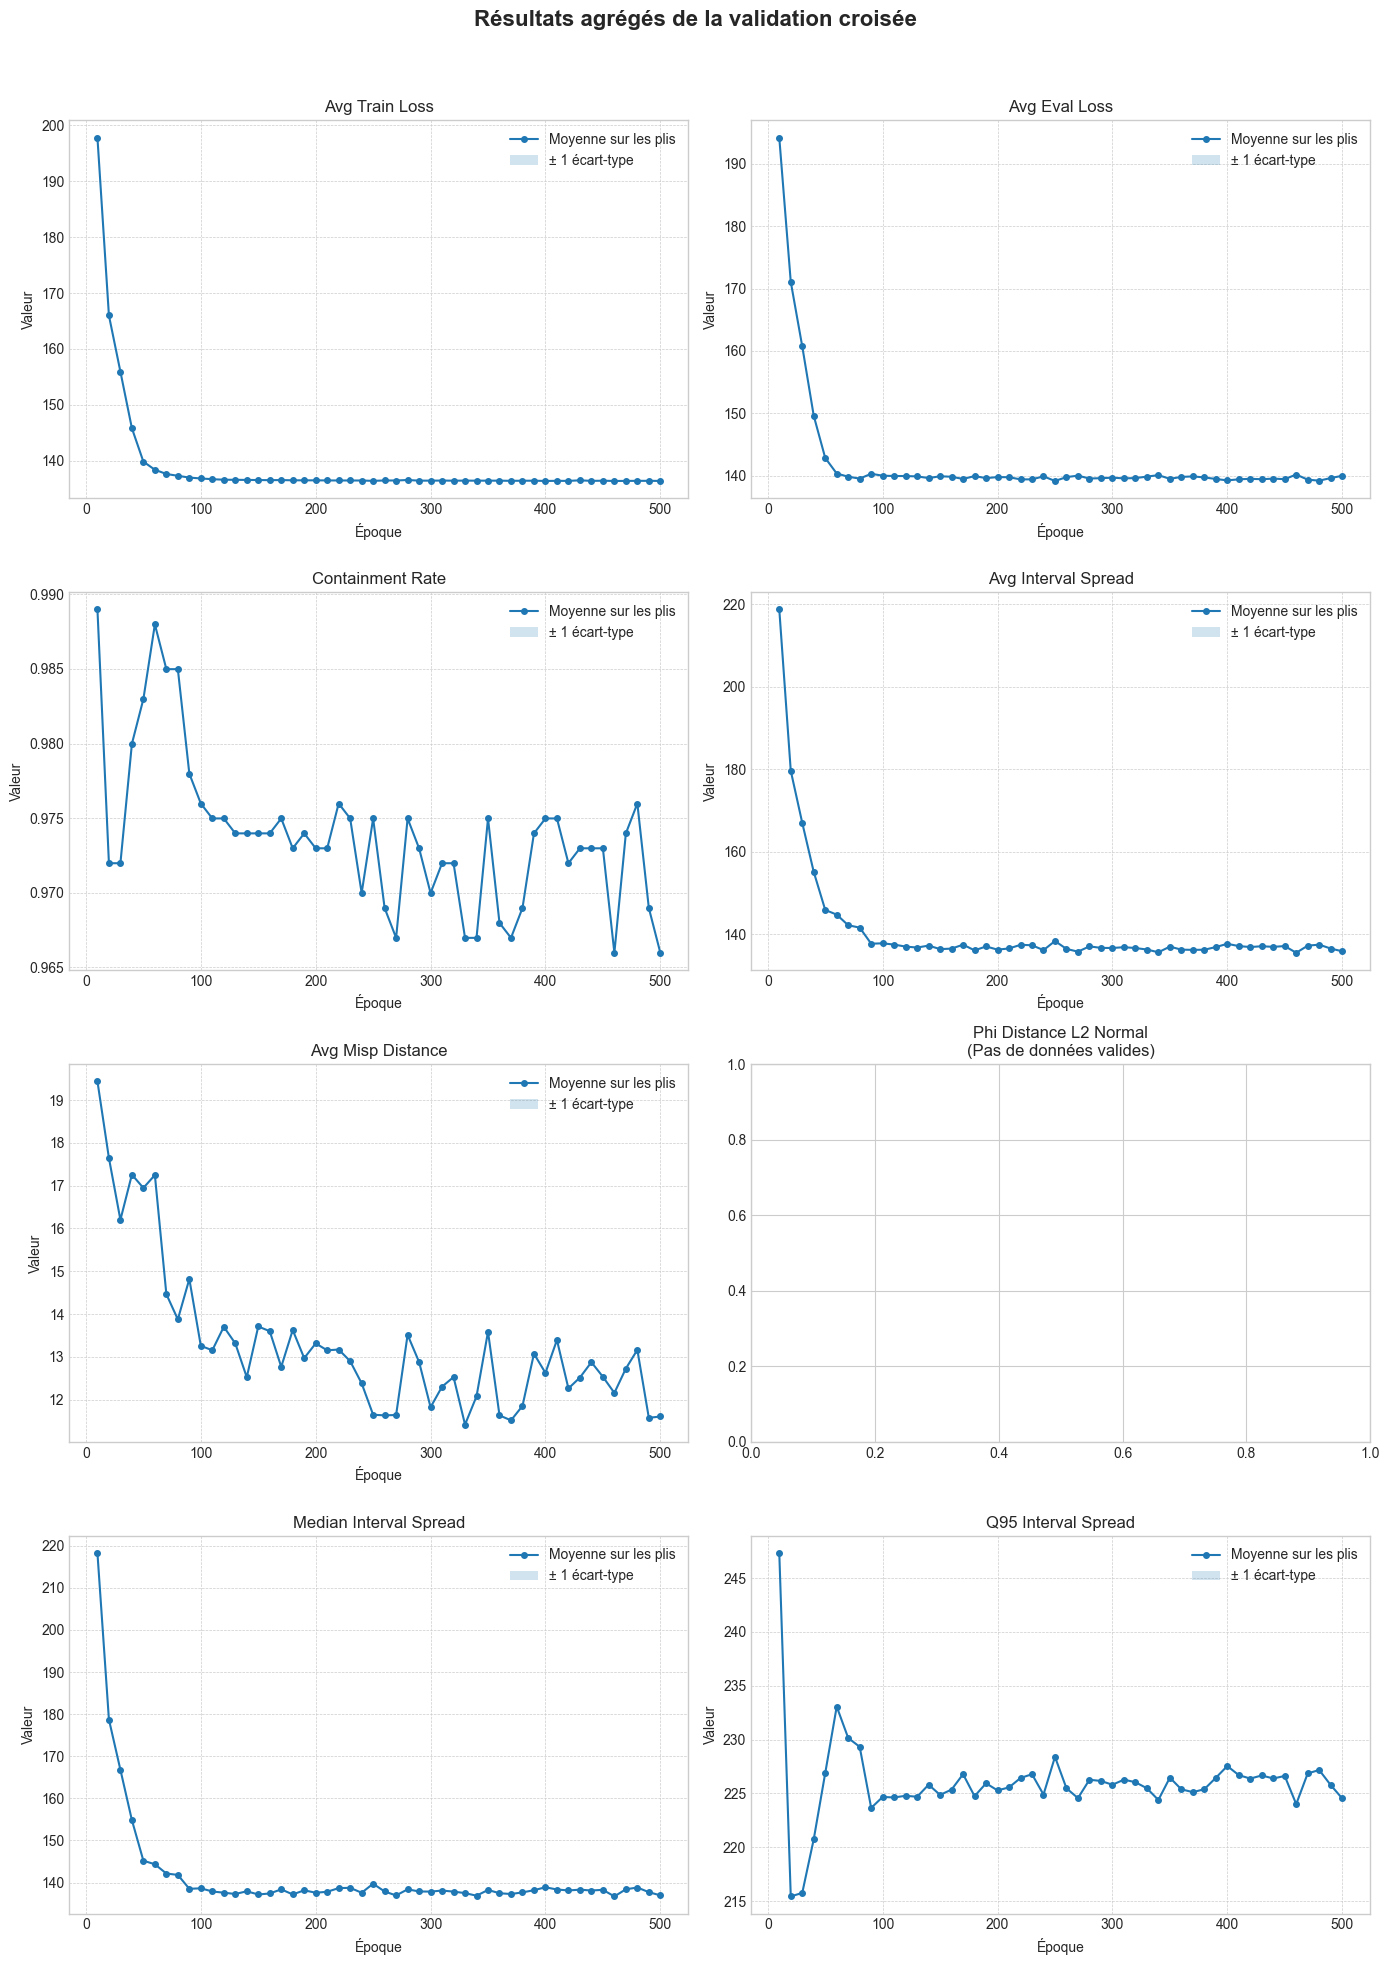

In [13]:
plot_metrics_complet([model.history,model.history])

In [59]:
# Conversion de X en tenseur torch
X_tensor = torch.tensor(X, dtype=torch.float64)
# Appel du modèle une seule fois
tops, bots = model.forward(X_tensor) 
tops = tops.detach().numpy()
bots = bots.detach().numpy()
# Moyenne élément par élément
Y_pred = ((tops + bots) / 2)
Y_pred_bot,Y_pred_top = tops,bots
print(Y_pred,Y_pred_bot,Y_pred_top)

[134.01831268  28.91824367  22.11805623 ... 190.86611915 109.59969948
  95.21304955] [ 46.56274676 -59.53095516 -67.62339691 ...  63.40726121  17.09979702
  11.46098311] [221.47387861 117.3674425  111.85950937 ... 318.3249771  202.09960194
 178.96511599]


In [60]:
rmsle = np.sqrt( mean_squared_log_error(Y, abs(Y_pred)))
rmsle_t = np.sqrt(mean_squared_log_error(Y, abs(Y_pred_top)))
rmsle_b = np.sqrt(mean_squared_log_error(Y, abs(Y_pred_bot)))
print("RMSLE =", rmsle,rmsle_b,rmsle_t)

RMSLE = 0.31735113544589566 1.5651054581361352 1.162579552335557


In [8]:
model = CatBoostClassifier(iterations=1000, verbose=10)
model.fit(X[:5000],Y[:5000], eval_set=(X[:5001], Y[:5001]))
print(model.predict(X[0]))

Learning rate set to 0.111508
0:	learn: 5.4850126	test: 5.4849433	best: 5.4849433 (0)	total: 120ms	remaining: 2m
10:	learn: 4.5913112	test: 4.5910350	best: 4.5910350 (10)	total: 1.31s	remaining: 1m 58s
20:	learn: 4.1733110	test: 4.1729760	best: 4.1729760 (20)	total: 2.58s	remaining: 2m
30:	learn: 3.8983302	test: 3.8980102	best: 3.8980102 (30)	total: 3.95s	remaining: 2m 3s
40:	learn: 3.6800407	test: 3.6797314	best: 3.6797314 (40)	total: 5.33s	remaining: 2m 4s
50:	learn: 3.5330747	test: 3.5328003	best: 3.5328003 (50)	total: 6.84s	remaining: 2m 7s
60:	learn: 3.3772500	test: 3.3769996	best: 3.3769996 (60)	total: 8.34s	remaining: 2m 8s
70:	learn: 3.2359398	test: 3.2357096	best: 3.2357096 (70)	total: 9.84s	remaining: 2m 8s
80:	learn: 3.1343508	test: 3.1341275	best: 3.1341275 (80)	total: 11.4s	remaining: 2m 9s
90:	learn: 3.0410450	test: 3.0408366	best: 3.0408366 (90)	total: 12.9s	remaining: 2m 8s
100:	learn: 2.9537730	test: 2.9535816	best: 2.9535816 (100)	total: 14.4s	remaining: 2m 8s
110:	le

In [9]:
Y_pred = [model.predict(x) for x in X]

In [11]:
rmsle = np.sqrt( mean_squared_log_error(Y, Y_pred))
rmsle_t =0# np.sqrt(mean_squared_log_error(Y, abs(Y_pred_top)))
rmsle_b = 0#np.sqrt(mean_squared_log_error(Y, abs(Y_pred_bot)))
print("RMSLE =", rmsle,rmsle_b,rmsle_t)

RMSLE = 0.12012726817998667 0 0


In [22]:
epsil = 1
Y_pred_b = np.array(Y_pred)-epsil
Y_pred_t= np.array(Y_pred)+epsil

In [23]:
rmsle = np.sqrt( mean_squared_log_error(Y, Y_pred))
rmsle_t =np.sqrt(mean_squared_log_error(Y, Y_pred_t))
rmsle_b = np.sqrt(mean_squared_log_error(Y, Y_pred_b))
print("RMSLE =", rmsle,rmsle_b,rmsle_t)

RMSLE = 0.12012726817998667 0.12958906620404004 0.12962638322642864
